In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


In [3]:
data_path="../../../../data"
processed_data_path=f"{data_path}/processed/fMRI"


labels=np.load(f"{processed_data_path}/Labels.npy")
lesion_overlap_aal=np.load(f"{processed_data_path}/Lesion_Overlap_AAL.npy")
pos_str_aal=np.load(f"{processed_data_path}/Mean_Str_Pos_AAL.npy")
neg_str_aal=np.load(f"{processed_data_path}/Mean_Str_Neg_AAL.npy")
lesion_overlap_sch=np.load(f"{processed_data_path}/Lesion_Overlap_SCH.npy")
pos_str_sch=np.load(f"{processed_data_path}/Mean_Str_Pos_SCH.npy")
neg_str_sch=np.load(f"{processed_data_path}/Mean_Str_Neg_SCH.npy")
subjects_aal=[]
with open(f"{processed_data_path}/Lesion_Overlap_AAL_Subjects.txt","r") as f:
    subjects_aal=f.read().splitlines()
subjects_aal=np.array(subjects_aal).astype(float)

In [4]:
useable_subjects,label_ind,aal_ind=np.intersect1d(labels[:,0],subjects_aal,return_indices=True)


In [5]:
y=labels[label_ind,1]
x_pos_aal=pos_str_aal[:,aal_ind]
x_neg_aal=neg_str_aal[:,aal_ind]
x_over_aal=lesion_overlap_aal[:,aal_ind]
x_pos_sch=pos_str_sch[:,aal_ind]
x_neg_sch=neg_str_sch[:,aal_ind]
x_over_sch=lesion_overlap_sch[:,aal_ind]

In [6]:
def quick_plot(x_plot,y_plot,x_string,save_flag=False):
    ''' Plots histogram of x based on the labels in y and uses string as the label
    '''
    
    fig,(ax1,ax2,ax3)=plt.subplots(nrows=1,ncols=3,figsize=(15, 5),sharex=True)
    fig.suptitle(f'Histogram of {x_string}')

    ax1.hist(x_plot)
    ax1.set(xlabel=x_string,ylabel='Counts',title=f'All Subjects')
    #ax1.ylabel('Counts')
    #ax1.title(f'All Subjects')

    ax2.hist(x_plot[y_plot==1])
    ax2.set(xlabel=x_string,ylabel='Counts',title=f'Seizure Subjects')
    

    ax3.hist(x_plot[y_plot==0])
    ax3.set(xlabel=x_string,ylabel='Counts',title=f'Control Subjects')
    if save_flag:
        plt.savefig(f"{x_string} histogram.jpeg")



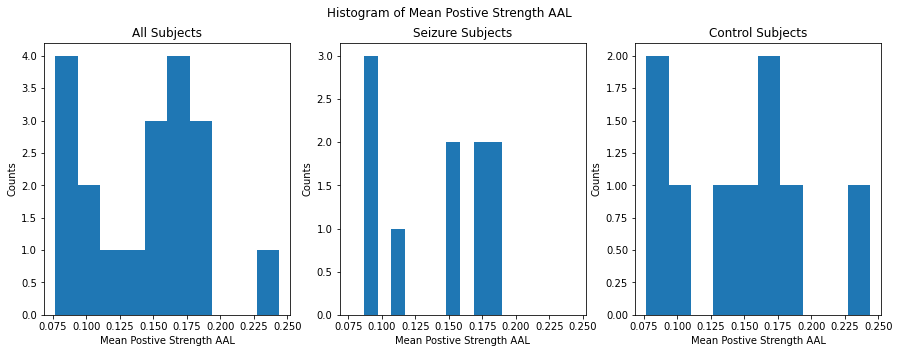

In [7]:
#EDA!
quick_plot(x_pos_aal.mean(axis=0),y,"Mean Postive Strength AAL",save_flag=False)

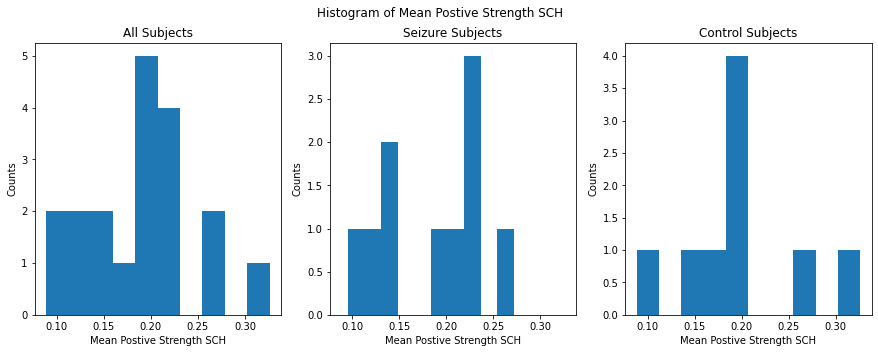

In [8]:
quick_plot(x_pos_sch.mean(axis=0),y,"Mean Postive Strength SCH",save_flag=False)

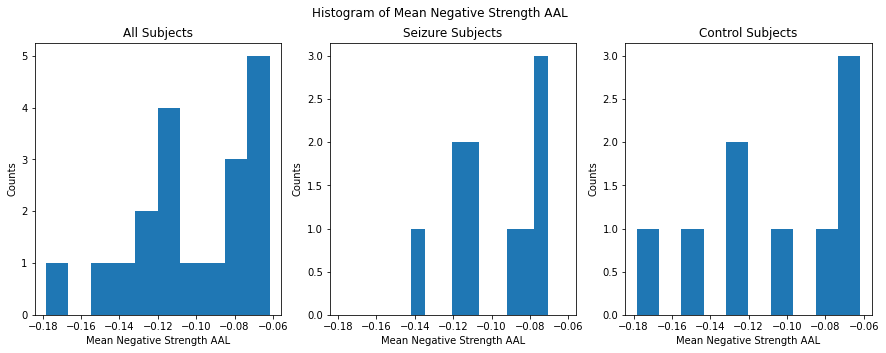

In [9]:
quick_plot(x_neg_aal.mean(axis=0),y,"Mean Negative Strength AAL",save_flag=False)

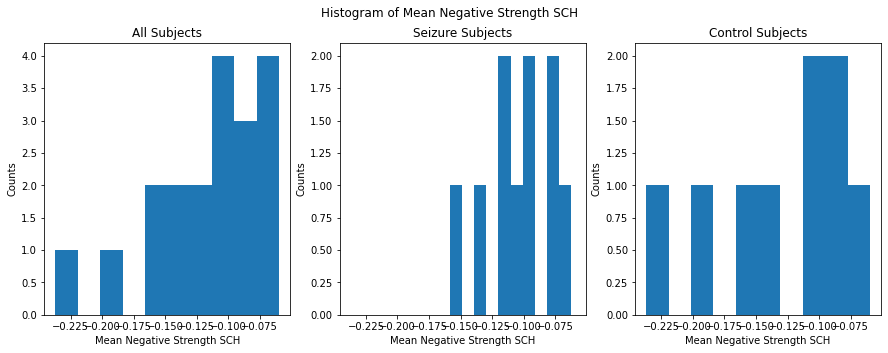

In [10]:
quick_plot(x_neg_sch.mean(axis=0),y,"Mean Negative Strength SCH",save_flag=False)

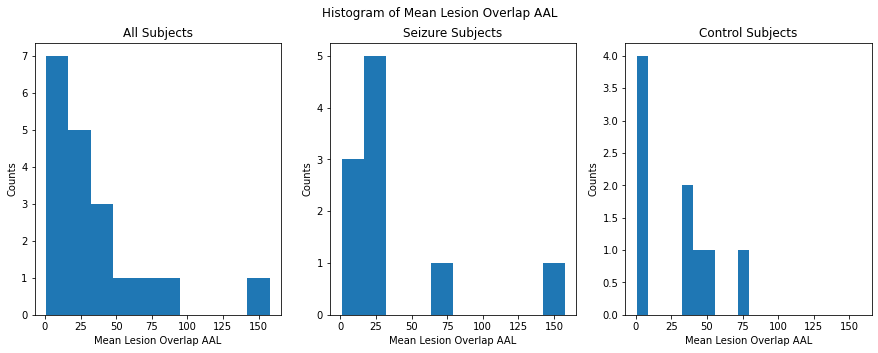

In [11]:
quick_plot(x_over_aal.mean(axis=0),y,"Mean Lesion Overlap AAL",save_flag=False)

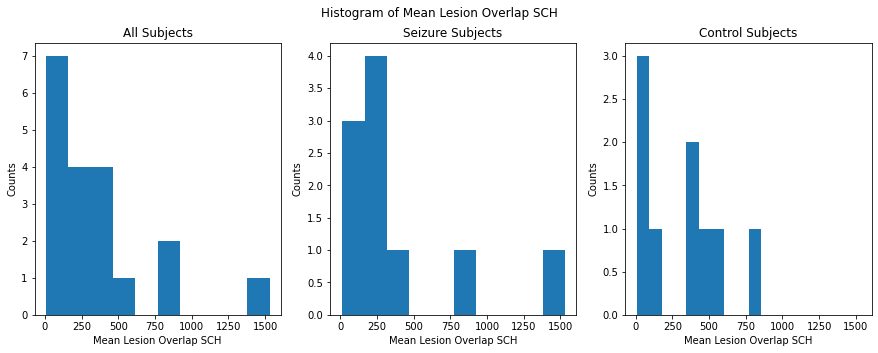

In [12]:
quick_plot(x_over_sch.mean(axis=0),y,"Mean Lesion Overlap SCH",save_flag=False)

In [14]:
def pca_plot(x_plot,y_plot,label_string,pca_kernel,pca_gamma,save_flag=False):
    ''' Transforms x_plot to two dimensions with PCA and makes a scatter plot titled with label_string, colored by y_plot. '''

    if x_plot.shape[0]>y_plot.shape[0]: 
        x_pca=KernelPCA(n_components=2,kernel=pca_kernel.lower(),gamma=pca_gamma).fit_transform(x_plot.transpose())
    else: 
        x_pca=KernelPCA(n_components=2,kernel=pca_kernel.lower(),gamma=pca_gamma).fit_transform(x_plot)

    plt.plot(x_pca[y_plot==1,0],x_pca[y_plot==1,1],'b+')
    plt.plot(x_pca[y_plot==0,0],x_pca[y_plot==0,1],'g+')

    plt.legend(labels=['Seizure','No Seizure'])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA plot of {label_string} with {pca_kernel} kernel')

    plt.show()

    if save_flag:
        plt.savefig(f"PCA {label_string} {pca_kernel} {str(pca_gamma)}.jpeg")

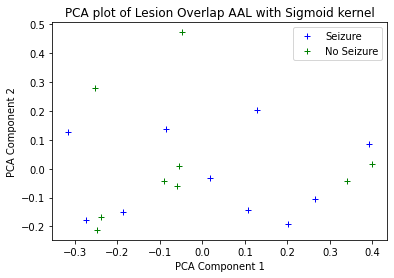

In [15]:
pca_plot(x_over_aal,y,'Lesion Overlap AAL','Sigmoid',.00001,save_flag=False)

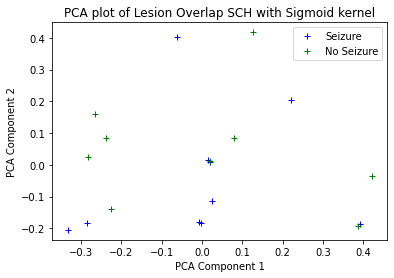

In [16]:
pca_plot(x_over_sch,y,'Lesion Overlap SCH','Sigmoid',.00001,save_flag=False)

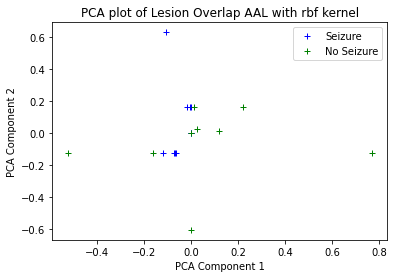

<Figure size 432x288 with 0 Axes>

In [17]:
pca_plot(x_over_aal,y,'Lesion Overlap AAL','rbf',1,save_flag=False)

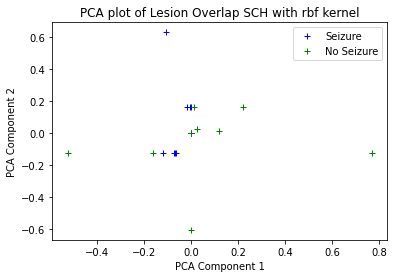

In [19]:
pca_plot(x_over_sch,y,'Lesion Overlap SCH','rbf',1,save_flag=False)

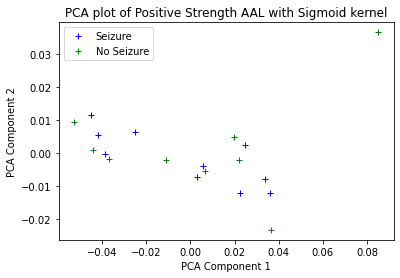

In [18]:
pca_plot(x_pos_aal,y,'Positive Strength AAL','Sigmoid',.01,save_flag=False)

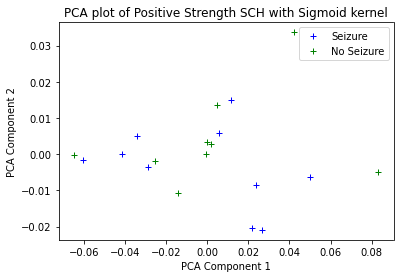

In [20]:
pca_plot(x_pos_sch,y,'Positive Strength SCH','Sigmoid',.01,save_flag=False)

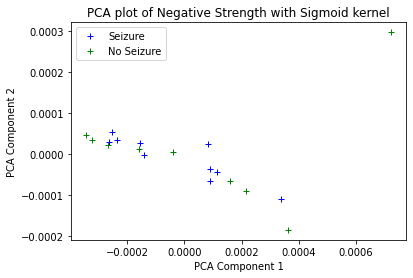

<Figure size 432x288 with 0 Axes>

In [111]:
pca_plot(x_neg_aal,y,'Negative Strength AAL','Sigmoid',.000001,save_flag=False)

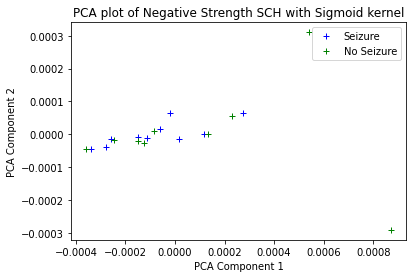

In [21]:
pca_plot(x_neg_sch,y,'Negative Strength SCH','Sigmoid',.000001,save_flag=False)

In [27]:
def compare_features(x,y,cv_inner,cv_outer,score_string,feature_string):
    ''' Prints performance based on nested CV of kPCA combined with SVC and Decision Tree Classifier for x and y.
    '''
    pipe_svc=Pipeline([("scale",StandardScaler()),("pca",KernelPCA()),("svm",SVC(probability=True))])
    param_grid_svc={"pca__n_components":[2,3,4,5,6],"pca__gamma":[.01,.05,.1],"pca__kernel":["sigmoid","rbf"],
    "svm__C": [1, 10, 100], "svm__gamma": [.01, .1]}

    search_svc=GridSearchCV(estimator=pipe_svc,scoring=score_string,param_grid=param_grid_svc,cv=cv_inner,refit=True)
    scores_svc = cross_val_score(search_svc, x, y, scoring=score_string, cv=cv_outer, n_jobs=-1)

    print(f"Score {feature_string} for kPCA and SVM")
    print(f"Mean {scores_svc.mean()} and STD {scores_svc.std()}")
    
    pipe_rf=Pipeline([("scale",StandardScaler()),("pca",KernelPCA()),("rf",RandomForestClassifier() )])
    param_grid_rf={"pca__n_components":[2,3,4,5,6],"pca__gamma":[.01,.05,.1],"pca__kernel":["sigmoid","rbf"],
    "rf__n_estimators": [10, 50, 100]}

    search_rf=GridSearchCV(estimator=pipe_rf,scoring=score_string,param_grid=param_grid_rf,cv=cv_inner,refit=True)


    scores_rf = cross_val_score(search_rf, x, y, scoring=score_string, cv=cv_outer, n_jobs=-1)

    print(f"Score {feature_string} for kPCA and RF")
    print(f"Mean {scores_rf.mean()} and STD {scores_rf.std()}")


In [25]:

#xgb=XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cv_outer=StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
cv_inner=KFold(n_splits=3,shuffle=True,random_state=42)



In [28]:
compare_features(x_pos_aal.transpose(),y,cv_inner,cv_outer,"f1","Positive Strength AAL")
compare_features(x_pos_sch.transpose(),y,cv_inner,cv_outer,"f1","Positive Strength SCH")

Score Positive Strength AAL for kPCA and SVM
Mean 0.5714285714285714 and STD 0.08247860988423222
Score Positive Strength AAL for kPCA and RF
Mean 0.38095238095238093 and STD 0.36421567954234174
Score Positive Strength SCH for kPCA and SVM
Mean 0.7380952380952381 and STD 0.1749635530559413
Score Positive Strength SCH for kPCA and RF
Mean 0.7761904761904762 and STD 0.16970028267814724


In [29]:
compare_features(x_neg_aal.transpose(),y,cv_inner,cv_outer,"f1","Negative Strength AAL")
compare_features(x_neg_sch.transpose(),y,cv_inner,cv_outer,"f1","Negative Strength SCH")

Score Negative Strength AAL for kPCA and SVM
Mean 0.5190476190476191 and STD 0.35717460176379384
Score Negative Strength AAL for kPCA and RF
Mean 0.44761904761904764 and STD 0.4011321845457655
Score Negative Strength SCH for kPCA and SVM
Mean 0.4952380952380952 and STD 0.3520590550338004
Score Negative Strength SCH for kPCA and RF
Mean 0.44761904761904764 and STD 0.2991295004674173


In [30]:
compare_features(x_over_aal.transpose(),y,cv_inner,cv_outer,"f1","Lesion Overlap AAL")
compare_features(x_over_sch.transpose(),y,cv_inner,cv_outer,"f1","Lesion Overlap SCH")

Score Lesion Overlap AAL for kPCA and SVM
Mean 0.39999999999999997 and STD 0.38172540616821105
Score Lesion Overlap AAL for kPCA and RF
Mean 0.4714285714285714 and STD 0.30882705461125637
Score Lesion Overlap SCH for kPCA and SVM
Mean 0.42380952380952375 and STD 0.3922722919355995
Score Lesion Overlap SCH for kPCA and RF
Mean 0.4952380952380952 and STD 0.3520590550338004
